In [37]:
import pandas as pd
import math
import numpy as np
from sklearn import tree

In [38]:
team_name_all=["愛媛","横浜","岡山","岐阜","京都","金沢","熊本","甲府","山形","山口","讃岐","鹿児島","松本","湘南","新潟","水戸","千葉","群馬","大宮","大分","町田","長崎","東京","徳島","栃木","柏","福岡","名古屋","琉球"]
team_number_all=["37","34","42","39","24","275","38","28","29","330","48","338","46","12","78","94","2","35","27","31","45","47","4","36","40","11","23","8","277"]

In [39]:
all_team=[]
kion=[]
for i in range(29):
    team_name=team_name_all[i]
    team_number=team_number_all[i]
    url=f"https://data.j-league.or.jp/SFMS01/search?competition_years=2019&competition_years=2018&competition_years=2017&competition_frame_ids=2&team_ids={team_number}&home_away_select=1&tv_relay_station_name="
    fomerdata=pd.read_html(url,header=0)
    data=fomerdata[0].drop(["大会","スタジアム"],axis=1)
    game_day=data.試合日
    game_day=[s.replace("月・祝","月").replace("火・祝","火").replace("水・祝","水").replace("木・祝","木").replace("金・祝","金").replace("土・祝","土").replace("日・祝","日").replace("月・休","月") for s in game_day]
    day=data.年度.astype(str)+"/"+game_day
    day=pd.DataFrame({"年/月/日":day})
    data=pd.concat([data,day],axis=1)
    tenki=pd.read_excel(f"c:\\Users\\梅津魁秀\\Desktop\\卒業研究\\天気データ\\全国天気\\{team_name}.xlsx",skiprows=3)
    tenki=tenki.fillna(0)
    tenki=tenki.drop(tenki.index[[0]]).reset_index(drop=True)
    tenki=tenki.drop(tenki.index[1095])
    google_trend=pd.read_csv("gt.csv").drop(["Unnamed: 0"],axis=1)
    google_trend=google_trend[f"{team_name}"]
    tenki=pd.concat([tenki,google_trend],axis=1)
    tenki=tenki.rename(columns={f"{team_name}":"ホームトレンド"})
    day2=tenki.年.round().astype(int).astype(str)+"/"+tenki.月.round().astype(int).astype(str).str.zfill(2)+"/"+tenki.日.round().astype(int).astype(str).str.zfill(2)+"("+tenki.曜日+")"
    day2=pd.DataFrame({"年/月/日":day2})
    tenki=pd.concat([tenki,day2],axis=1)
    data=pd.merge(data,tenki[["年/月/日","平均気温(℃)","降水量の合計(mm)","日照時間(時間)","ホームトレンド"]],on="年/月/日",how="left")
    sec=data.節.str.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))
    sec=sec.str.extract("(.+)節",expand=True).rename(columns={0:"節数"})
    data=pd.concat([data,sec],axis=1)
    rank=pd.read_csv("c:\\Users\\梅津魁秀\\anaconda3\\rank.csv").drop(["Unnamed: 0"],axis=1)
    rank2=rank.rename(columns={"アウェイ":"ホーム"})
    data=pd.merge(data,rank[["アウェイ","節数","年度","順位"]],on=["アウェイ","年度","節数"],how="left")
    data=pd.merge(data,rank2[["ホーム","節数","年度","順位"]],on=["ホーム","年度","節数"],how="left")
    data=data.rename(columns={"順位_x":"アウェイ順位","順位_y":"ホーム順位"})
    data["節数"]=data["節数"].str.replace('第', '')
    data["K/O時刻"]=data["K/O時刻"].str[:2]
    score=data.スコア.str.split('-', expand=True)
    score=score[[0,1]].astype(np.int64)
    data["点数(ホームーアウェイ)"]=score[0]-score[1]
    data=data.drop(["年度","節","試合日","ホーム","インターネット中継・TV放送","年/月/日","アウェイ","スコア"],axis=1)
    #入場者数と平均気温に関しては、その地域ごとに偏差をとり、データに反映する。
    visitors=int(data["入場者数"].mean())
    temperature＿mean=int(data["平均気温(℃)"].mean())
    kion.append({temperature＿mean:team_name})
    #それぞれ平均を引いた値を出力する。
    data["平均気温(℃)"]=round(data["平均気温(℃)"]-temperature＿mean,1)
    data["入場者数"]=data["入場者数"]-visitors
    all_team.append(data)

In [40]:
#forループでリストにしっかり格納されたか個数をチェック(29個であれば成功)
print(len(all_team))
#リストを全て合わせてall_team_kanseiとする。
all_team_kansei=pd.concat(all_team)
#データを行方向でシャッフル
#再度reset_indexを↓で行うことで、行番号を再度設定する。
# all_team_kansei=all_team_kansei.sample(frac=1)
all_team_kansei=all_team_kansei.astype('float64').reset_index(drop=True)
# all_team_kansei.to_csv("a.csv")
all_team_kansei

29


,K/O時刻,入場者数,平均気温(℃),降水量の合計(mm),日照時間(時間),ホームトレンド,節数,アウェイ順位,ホーム順位,点数(ホームーアウェイ)
0,15.0,2113.0,-11.2,0.0,4.9,51.0,1.0,16.0,6.0,1.0
1,15.0,43.0,-9.1,0.0,4.7,50.0,2.0,19.0,8.0,0.0
2,15.0,-109.0,-8.0,0.0,10.7,28.0,4.0,1.0,14.0,-1.0
3,15.0,164.0,-2.3,0.5,1.6,51.0,7.0,20.0,12.0,1.0
4,15.0,-1322.0,-1.8,0.0,10.4,38.0,9.0,9.0,13.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1381,19.0,-2269.0,3.1,8.5,0.6,35.0,31.0,20.0,15.0,1.0
1382,19.0,-1866.0,2.5,0.0,3.9,20.0,33.0,2.0,15.0,0.0
1383,18.0,-146.0,2.3,0.0,6.2,33.0,36.0,13.0,15.0,-4.0
1384,13.0,3050.0,-0.7,0.0,3.4,100.0,38.0,4.0,15.0,-1.0


In [11]:
#説明変数となるものをそれぞれx1~x9まで作成
x1=np.array(all_team_kansei["K/O時刻"])
x2=np.array(all_team_kansei["平均気温(℃)"])
x3=np.array(all_team_kansei["降水量の合計(mm)"])
x4=np.array(all_team_kansei["日照時間(時間)"])
x5=np.array(all_team_kansei["節数"])
x6=np.array(all_team_kansei["アウェイ順位"])
x7=np.array(all_team_kansei["ホーム順位"])
x8=np.array(all_team_kansei["点数(ホームーアウェイ)"])
x9=np.array(all_team_kansei["ホームトレンド"])
#目的変数(観客動員数)をyに入れる
y=np.array(all_team_kansei["入場者数"])
X=np.c_[x1,x2,x3,x4,x5,x6,x7,x8,x9]#SVRが使えるように変数を結合
# print(X.dtype,y.dtype)

In [12]:
#各項目を整理するために、ヒストグラムに出力する。
#標準化未実装
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties 
#日本語を表示するにはこうするらしい 
fp = FontProperties(fname=r'C:\WINDOWS\Fonts\msgothic.ttc', size=16) 

Counter({14.0: 424, 19.0: 331, 18.0: 267, 15.0: 141, 16.0: 112, 13.0: 88, 17.0: 22, 12.0: 1})
8


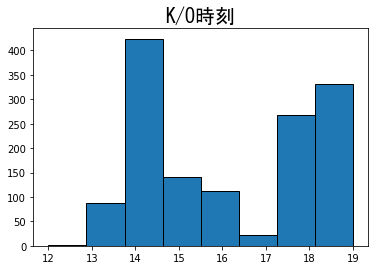

In [13]:
#x1と同様に他のデータも行うので、説明ここだけであとは省略する。
print(collections.Counter(x1))#種類とその個数を出力
print(len(collections.Counter(x1)))#種類数を出力
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x1, bins=8, histtype='barstacked', ec='black')#binで何個の棒の数を決める(今回は種類数にしている)
plt.title("K/O時刻", fontsize=20,fontproperties=fp)
plt.show()

In [14]:
print(kion)

[{19: '愛媛'}, {19: '横浜'}, {19: '岡山'}, {20: '岐阜'}, {19: '京都'}, {18: '金沢'}, {21: '熊本'}, {19: '甲府'}, {16: '山形'}, {18: '山口'}, {19: '讃岐'}, {21: '鹿児島'}, {16: '松本'}, {19: '湘南'}, {18: '新潟'}, {17: '水戸'}, {19: '千葉'}, {18: '群馬'}, {19: '大宮'}, {19: '大分'}, {19: '町田'}, {20: '長崎'}, {19: '東京'}, {20: '徳島'}, {18: '栃木'}, {19: '柏'}, {20: '福岡'}, {19: '名古屋'}, {24: '琉球'}]


Counter({3.7: 16, 1.9: 15, 2.4: 13, 1.4: 13, -1.8: 12, 2.3: 12, 0.0: 12, -1.1: 12, -1.3: 11, 10.7: 11, 3.3: 11, -0.1: 11, -1.9: 11, 2.7: 11, -1.0: 11, -0.7: 11, 2.5: 10, -2.2: 10, 9.9: 10, 4.1: 10, 2.0: 10, 5.6: 10, -1.6: 10, 10.5: 9, 10.9: 9, -2.0: 9, 6.2: 9, 3.8: 9, -0.3: 9, -0.2: 9, 3.0: 9, 4.3: 9, 1.6: 9, -2.4: 9, 0.4: 8, 9.5: 8, -1.7: 8, -10.4: 8, -2.9: 8, 6.9: 8, 3.2: 8, 8.7: 8, 0.7: 8, -0.6: 8, 3.1: 8, 5.2: 8, 0.9: 8, 4.8: 8, 5.3: 8, 4.4: 8, -11.2: 7, 9.6: 7, -10.3: 7, -1.5: 7, 1.2: 7, 6.0: 7, 6.4: 7, 1.8: 7, -9.8: 7, 6.7: 7, -2.5: 7, -4.8: 7, 1.5: 7, 10.4: 7, 8.5: 7, 9.1: 7, -5.7: 7, 7.2: 7, -1.4: 7, -4.6: 7, 4.0: 7, 5.5: 7, 11.2: 7, 9.8: 6, -2.7: 6, 2.9: 6, -3.7: 6, 7.1: 6, 1.7: 6, -10.8: 6, -4.0: 6, -6.7: 6, -9.2: 6, -3.4: 6, 6.6: 6, 3.4: 6, -3.5: 6, 11.0: 6, 7.5: 6, -12.2: 6, 7.8: 6, 9.4: 6, 2.2: 6, -11.0: 6, -2.1: 6, 8.6: 6, 10.3: 6, -11.1: 6, 4.5: 6, 5.1: 6, -10.5: 6, -3.0: 6, -6.3: 6, -3.9: 6, 10.0: 6, 8.9: 6, 3.9: 6, 1.0: 6, -2.3: 5, 8.2: 5, -4.5: 5, -10.9: 5, -5.4: 5, 4

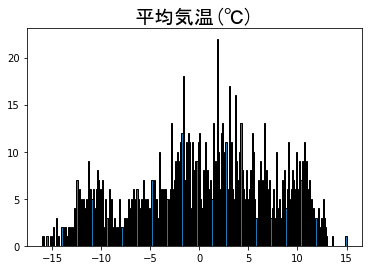

In [11]:
#データの編集が雑(入場者数にも言えるが)
print(collections.Counter(x2))
print(len(collections.Counter(x2)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x2, bins=284, histtype='barstacked', ec='black')
plt.title("平均気温(℃)", fontsize=20,fontproperties=fp)
plt.show()

Counter({0.0: 915, 0.5: 59, 1.0: 23, 2.0: 23, 1.5: 21, 2.5: 17, 3.5: 15, 3.0: 13, 9.0: 12, 6.0: 12, 4.5: 12, 4.0: 11, 8.5: 10, 5.0: 10, 6.5: 10, 5.5: 8, 7.5: 8, 10.0: 7, 14.0: 7, 15.0: 7, 7.0: 7, 13.0: 6, 14.5: 6, 11.5: 6, 16.0: 6, 16.5: 5, 12.0: 5, 11.0: 5, 8.0: 5, 29.5: 5, 19.5: 5, 18.5: 5, 20.0: 4, 39.0: 4, 10.5: 4, 27.0: 4, 15.5: 4, 23.5: 4, 17.0: 4, 12.5: 4, 25.0: 3, 9.5: 3, 20.5: 3, 17.5: 3, 13.5: 3, 25.5: 3, 29.0: 3, 41.0: 2, 46.0: 2, 18.0: 2, 80.0: 2, 60.0: 2, 19.0: 2, 30.0: 2, 31.0: 2, 21.0: 2, 36.5: 2, 43.0: 2, 21.5: 2, 22.5: 2, 35.0: 2, 24.0: 2, 30.5: 1, 22.0: 1, 63.0: 1, 46.5: 1, 98.5: 1, 59.0: 1, 40.0: 1, 28.5: 1, 110.5: 1, 82.0: 1, 91.5: 1, 44.0: 1, 45.5: 1, 23.0: 1, 126.0: 1, 65.0: 1, 38.0: 1, 124.5: 1, 66.5: 1, 34.5: 1, 39.5: 1, 32.5: 1, 47.0: 1, 66.0: 1, 88.5: 1, 37.5: 1, 28.0: 1, 93.5: 1, 33.5: 1, 53.5: 1, 26.5: 1, 56.5: 1, 44.5: 1, 24.5: 1, 55.0: 1, 92.0: 1, 32.0: 1})
138


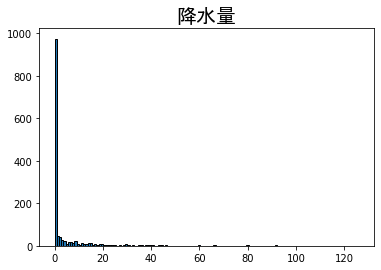

In [12]:
print(collections.Counter(x3))
print(len(collections.Counter(x4)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x3, bins=138, histtype='barstacked', ec='black')
plt.title("降水量", fontsize=20,fontproperties=fp)
plt.show()

Counter({0.0: 194, 0.1: 24, 9.7: 21, 9.5: 21, 0.6: 18, 11.3: 17, 6.7: 16, 10.2: 16, 11.7: 16, 9.3: 16, 0.5: 15, 9.4: 14, 0.4: 14, 0.3: 14, 10.4: 13, 9.1: 13, 11.1: 13, 0.2: 13, 8.3: 13, 11.2: 13, 8.5: 13, 12.3: 13, 9.6: 12, 6.8: 12, 6.6: 12, 11.5: 12, 12.5: 12, 7.7: 12, 10.7: 11, 1.6: 11, 8.0: 11, 1.7: 11, 12.1: 11, 10.3: 11, 10.0: 11, 8.8: 11, 2.6: 11, 0.7: 11, 7.3: 11, 2.9: 11, 3.4: 11, 3.9: 10, 10.6: 10, 5.3: 10, 9.8: 10, 8.7: 10, 9.0: 10, 12.2: 10, 5.8: 10, 6.1: 10, 3.6: 10, 12.0: 10, 8.1: 10, 11.4: 10, 4.7: 9, 10.1: 9, 8.9: 9, 8.4: 9, 13.0: 9, 7.6: 9, 5.9: 9, 6.9: 9, 8.6: 9, 0.8: 9, 9.2: 9, 9.9: 9, 5.7: 9, 7.1: 9, 11.0: 9, 10.8: 9, 7.2: 9, 11.9: 8, 12.4: 8, 4.8: 8, 13.1: 8, 7.8: 8, 12.7: 8, 5.6: 8, 12.8: 8, 12.6: 8, 6.5: 8, 7.0: 8, 2.1: 8, 3.0: 8, 1.0: 8, 4.1: 8, 10.9: 8, 1.8: 8, 3.2: 8, 11.6: 7, 11.8: 7, 2.4: 7, 4.5: 7, 4.4: 7, 6.2: 7, 7.9: 7, 5.0: 7, 1.3: 6, 10.5: 6, 1.9: 6, 2.8: 6, 4.0: 6, 1.4: 6, 6.0: 6, 7.4: 6, 4.9: 5, 2.7: 5, 3.7: 5, 1.1: 5, 3.3: 5, 3.5: 5, 3.1: 5, 8.2: 5, 5

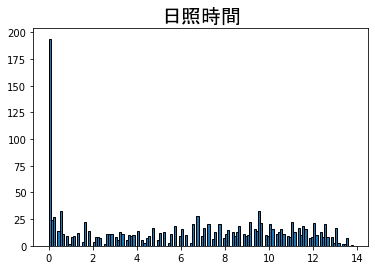

In [13]:
print(collections.Counter(x4))
print(len(collections.Counter(x4)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x4, bins=138, histtype='barstacked', ec='black')
plt.title("日照時間", fontsize=20,fontproperties=fp)
plt.show()

Counter({1.0: 33, 2.0: 33, 4.0: 33, 7.0: 33, 9.0: 33, 10.0: 33, 12.0: 33, 14.0: 33, 15.0: 33, 18.0: 33, 20.0: 33, 23.0: 33, 25.0: 33, 27.0: 33, 29.0: 33, 30.0: 33, 34.0: 33, 37.0: 33, 40.0: 33, 33.0: 33, 41.0: 33, 6.0: 33, 8.0: 33, 11.0: 33, 13.0: 33, 24.0: 33, 28.0: 33, 31.0: 33, 32.0: 33, 35.0: 33, 39.0: 33, 5.0: 33, 17.0: 33, 19.0: 33, 21.0: 33, 26.0: 33, 36.0: 33, 3.0: 33, 16.0: 33, 38.0: 33, 22.0: 33, 42.0: 33})
42


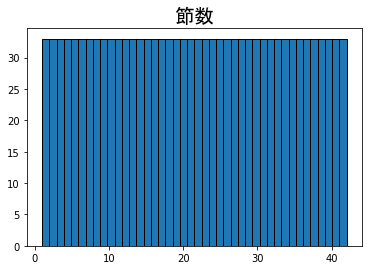

In [14]:
print(collections.Counter(x5))
print(len(collections.Counter(x5)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x5,bins=42, histtype='barstacked', ec='black')
plt.title("節数", fontsize=20,fontproperties=fp)
plt.show()

Counter({12.0: 70, 8.0: 70, 16.0: 67, 17.0: 67, 6.0: 67, 21.0: 67, 3.0: 66, 19.0: 65, 14.0: 65, 20.0: 64, 13.0: 64, 4.0: 63, 18.0: 63, 22.0: 62, 11.0: 61, 2.0: 61, 5.0: 60, 9.0: 59, 7.0: 59, 1.0: 56, 15.0: 56, 10.0: 54})
22


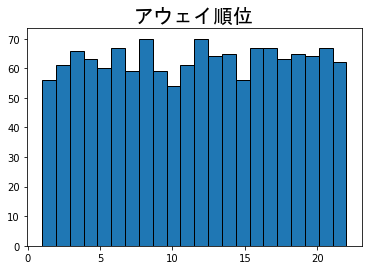

In [15]:
print(collections.Counter(x6))
print(len(collections.Counter(x6)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x6, bins=22, histtype='barstacked', ec='black')
plt.title("アウェイ順位", fontsize=20,fontproperties=fp)
plt.show()

Counter({1.0: 71, 10.0: 70, 15.0: 68, 11.0: 67, 5.0: 67, 7.0: 65, 18.0: 65, 4.0: 65, 13.0: 64, 16.0: 64, 22.0: 64, 9.0: 64, 2.0: 64, 6.0: 62, 3.0: 62, 8.0: 61, 21.0: 59, 19.0: 59, 20.0: 58, 17.0: 57, 14.0: 55, 12.0: 55})
22


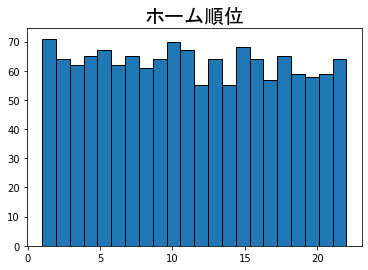

In [16]:
print(collections.Counter(x7))
print(len(collections.Counter(x7)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x7, bins=22, histtype='barstacked', ec='black')
plt.title("ホーム順位", fontsize=20,fontproperties=fp)
plt.show()

Counter({0.0: 357, 1.0: 325, -1.0: 298, 2.0: 138, -2.0: 106, 3.0: 57, -3.0: 44, 4.0: 29, -4.0: 17, 5.0: 9, -5.0: 2, 6.0: 2, -7.0: 1, 12.0: 1})
14


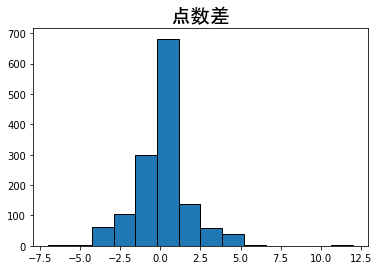

In [17]:
print(collections.Counter(x8))
print(len(collections.Counter(x8)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x8, bins=14, histtype='barstacked', ec='black')
plt.title("点数差", fontsize=20,fontproperties=fp)
plt.show()

Counter({30.0: 49, 27.0: 40, 33.0: 36, 20.0: 36, 29.0: 34, 24.0: 33, 42.0: 32, 39.0: 32, 34.0: 30, 51.0: 29, 32.0: 29, 53.0: 29, 26.0: 29, 28.0: 28, 36.0: 28, 41.0: 28, 23.0: 28, 37.0: 27, 19.0: 27, 22.0: 27, 45.0: 26, 31.0: 26, 17.0: 26, 21.0: 26, 25.0: 26, 35.0: 25, 46.0: 25, 15.0: 25, 16.0: 25, 40.0: 24, 18.0: 24, 13.0: 24, 14.0: 24, 44.0: 24, 48.0: 23, 54.0: 22, 52.0: 20, 50.0: 18, 38.0: 17, 47.0: 16, 43.0: 16, 56.0: 16, 63.0: 14, 55.0: 13, 10.0: 13, 12.0: 12, 100.0: 12, 49.0: 12, 60.0: 10, 11.0: 10, 66.0: 10, 57.0: 10, 67.0: 9, 62.0: 9, 9.0: 9, 61.0: 8, 58.0: 8, 64.0: 6, 70.0: 6, 68.0: 6, 59.0: 6, 65.0: 5, 75.0: 5, 84.0: 5, 69.0: 4, 78.0: 4, 73.0: 4, 77.0: 4, 76.0: 4, 71.0: 4, 74.0: 4, 8.0: 4, 81.0: 3, 97.0: 3, 90.0: 3, 87.0: 2, 86.0: 2, 83.0: 2, 82.0: 2, 79.0: 2, 72.0: 1, 91.0: 1, 85.0: 1, 80.0: 1, 94.0: 1, 99.0: 1, 7.0: 1, 96.0: 1})


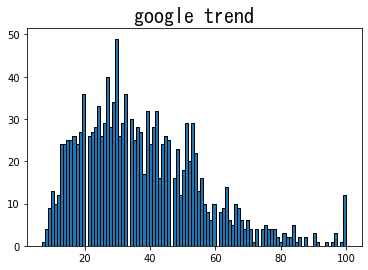

In [18]:
print(collections.Counter(x9))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x9, bins=100, histtype='barstacked', ec='black')
plt.title("google trend", fontsize=20,fontproperties=fp)
plt.show()

範囲設定

x1キックオフ時刻：x1<17,17<=x1\
x2平均気温：x2<-9,-9<=x2<10,10<=x2\
x5節数：x2<14,14<=x2<28,28<=x2\
x6アウェイ順位：x6<8,8<=x6<15,15<=x6\
x7ホーム順位：x6<8,8<=x6<15,15<=x6\
x9トレンド情報：x9<34,34<=x9<67,67<=x9

In [15]:
#周辺化準備
#データ数1386、3^6=729、3^7=2187であるので、説明変数は6項目がベスト
#K/O時刻で検証
#参考資料　https://www.gesource.jp/weblog/?p=8244
#使うのはx1,x2,x5,x6,x7,x9
#x1のみについて説明する（以下同順）
print(x1)#x1の中身を出力。
r_x1=np.array([17])
#分類範囲を決める(例：[1,3]の場合はx<1,1<=x<3,3<=xの3種類に分類できる。)範囲の個数？を増やせば分類個数を増やすことも可能。
judge_x1=np.digitize(x1,r_x1)#実際に決めた範囲を用いてx1を分類し、judge_x1とする。
print(judge_x1)#judge_x1の中身を出力。

[15. 15. 15. ... 18. 13. 16.]
[0 0 0 ... 1 0 0]


In [16]:
#x2~x9まで同様の作業を行う
print(x2)
r_x2=np.array([-9,10])
judge_x2=np.digitize(x2,r_x2)
print(judge_x2)
print(x5)
r_x5=np.array([14,28])
judge_x5=np.digitize(x5,r_x5)
print(judge_x5)
print(x6)
r_x6=np.array([8,15])
judge_x6=np.digitize(x6,r_x6)
print(judge_x6)
print(x7)
r_x7=np.array([8,15])
judge_x7=np.digitize(x7,r_x7)
print(judge_x7)
print(x9)
r_x9=np.array([34,67])
judge_x9=np.digitize(x9,r_x9)
print(judge_x9)

[-11.2  -9.1  -8.  ...   2.3  -0.7  -2.3]
[0 0 1 ... 1 1 1]
[ 1.  2.  4. ... 36. 38. 40.]
[0 0 0 ... 2 2 2]
[16. 19.  1. ... 13.  4.  8.]
[2 2 0 ... 1 0 1]
[ 6.  8. 14. ... 15. 15. 15.]
[0 1 1 ... 2 2 2]
[ 51.  50.  28. ...  33. 100.  43.]
[1 1 0 ... 0 2 1]


In [22]:
#x1~x9までそれぞれの項目について分類したので、それを結合し、1386データを729グループに分類する。
#判定結果をstr(文字列)に直し、縦方向でつなげる。
classification=[]
for t in range(len(judge_x1)):
    classification.append(str(judge_x1[t])+str(judge_x2[t])+str(judge_x5[t])
             +str(judge_x6[t])+str(judge_x7[t])+str(judge_x9[t]))

print(len(classification))    
print(classification)

1386
['000201', '000211', '010010', '010211', '010111', '010111', '010211', '111202', '011012', '111201', '111011', '111112', '121121', '111121', '112210', '112010', '012020', '012221', '012021', '112221', '012221', '000011', '000122', '010121', '000121', '110221', '110121', '010021', '111221', '011020', '111221', '121222', '121122', '121021', '122021', '112221', '112220', '112020', '112221', '012020', '112021', '012021', '000111', '000201', '000210', '100110', '100121', '010211', '110221', '110021', '110221', '111021', '111021', '111021', '111022', '111121', '121121', '112012', '112111', '112221', '012122', '012221', '012122', '000200', '000200', '100000', '110200', '110200', '110100', '111200', '111000', '111200', '111000', '111000', '111200', '111000', '111000', '112100', '112200', '112100', '112010', '112210', '012210', '012110', '000110', '010200', '000010', '010110', '010110', '010110', '010200', '011200', '011200', '011200', '011100', '111100', '121100', '121000', '112200', '112

In [20]:
print(collections.Counter(classification))#先程と同様に種類とその数を出力
print(set(classification))#リスト内の重複を削除
print(len(set(classification)))#重複を削除後のデータ数を出力

Counter({'111210': 25, '112221': 22, '111100': 22, '111221': 20, '000201': 19, '010021': 19, '111200': 17, '111000': 17, '010200': 17, '012100': 17, '010210': 17, '012200': 17, '112210': 16, '112021': 16, '112200': 16, '012110': 16, '112000': 16, '012121': 16, '111121': 15, '012221': 15, '012021': 15, '012201': 15, '010121': 14, '012210': 14, '012011': 14, '010120': 14, '111211': 13, '112110': 13, '010020': 13, '111020': 13, '010100': 13, '010010': 12, '111201': 12, '012020': 12, '000011': 12, '112111': 12, '010110': 12, '012010': 12, '010000': 12, '010211': 11, '111011': 11, '121121': 11, '112010': 11, '000021': 11, '012211': 11, '111120': 11, '010220': 11, '010101': 11, '011201': 11, '010111': 10, '000200': 10, '000010': 10, '011200': 10, '010201': 10, '111001': 10, '111220': 10, '012220': 10, '000100': 10, '111010': 10, '011010': 10, '121021': 9, '000210': 9, '112100': 9, '000020': 9, '111110': 9, '010221': 9, '112211': 9, '112121': 9, '012022': 9, '012001': 9, '000121': 8, '011020'